# Multi-Layer Perceptron (MLP) with Pytorch on MNIST and FMNIST datasets
The following notebook consists of two artificial datasets. Even though the datasets are being exhaustively used,
it's a good practice to understand the underlying models for MLP.

In [4]:
# import essential packages
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.nn as nn
from torch import optim

from six.moves import urllib
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

%matplotlib inline
sns.set()

## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.


In [3]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


In [36]:
# number of subprocesses to use for data loading
num_workers = 0

# number of samples per batch to load
batch_size = 20
validation_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
print('Split:', split)

train_idx, valid_idx = indices[split:], indices[:split]

# define samples for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Split: 12000


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.


<ipython-input-12-6894b5ce51ef>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 30/2, idx + 1, xticks=[], yticks=[])


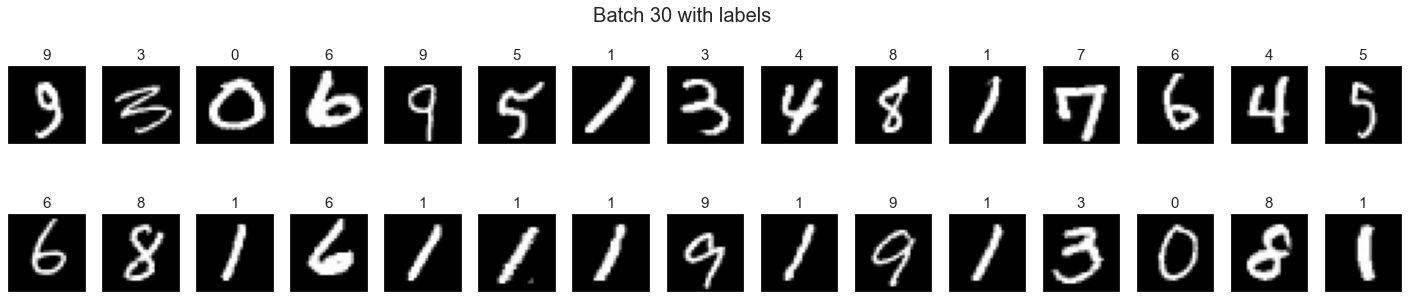

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot images with their labels
fig = plt.figure(figsize=(25, 5))
fig.suptitle('Batch 30 with labels', size=20)
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 30/2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()), size=15)
plt.show()

## View and Image in More Detail

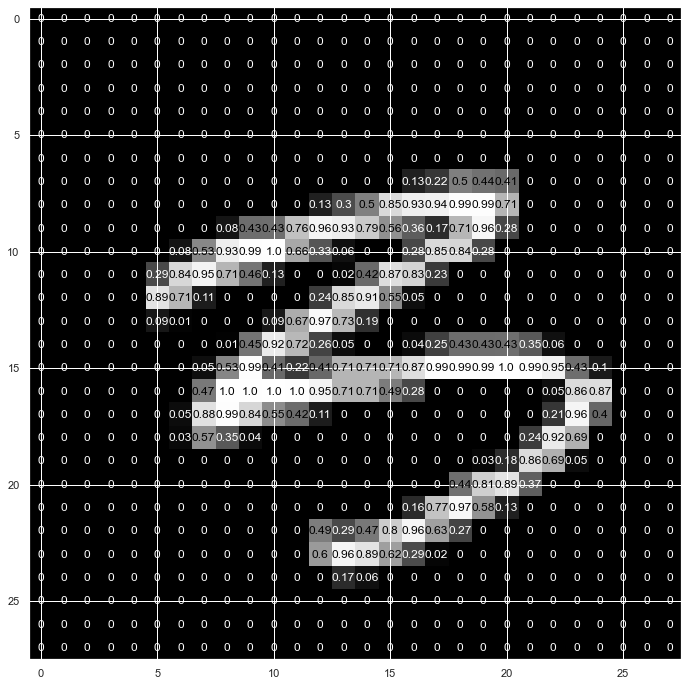

In [18]:
img = np.squeeze(images[1])

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

# filter out the numbers and plot normalized version
width, height = img.shape
thresh = img.max() / 2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] != 0 else 0
        ax.annotate(str(val), xy=(y, x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y] < thresh else 'black')

# Define Architecture

In [28]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # number of hidden layers
        hidden1 = 512
        hidden2 = 128
        hidden3 = 64

        self.fc1 = nn.Linear(28*28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.output = nn.Linear(hidden3, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten the array
        x = x.view(-1, 28*28)
        # hidden layer 1
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # hidden layer 2
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # hidden layer 3
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        # output layer
        x = F.log_softmax(self.output(x))
        return x

model = MLP()
model

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [29]:
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer (stochastic gradient descent)  and learning rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train the Network
Steps for <b>training/learning</b> from a batch of data are:
1. Clear the gradient of all optimized variables
2. Forward Pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: computer gradient of the loss with respect to the model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss


Steps for <b>validation</b> from a batch of data are:
1. Forward Pass: compute predicted outputs by passing inputs to the model
2. Calculate the loss
3. Update average validation loss
#### Basically, steps 2, 3, 6 from training steps

In [32]:
# number of epochs to train the model
n_epochs = 50

# keep track of training and validation loss for further visualization
vis_training_loss = []
vis_validation_loss = []

# initialize tracker for minimum validation loss
validation_loss_min = np.Inf

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ##############
    # Train Mode #
    ##############
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()                       # Step 1: clear the gradients
        output = model(data)                        # Step 2: forward pass
        loss = criterion(output, target)            # Step 3: calculate loss
        loss.backward()                             # Step 4: backward pass
        optimizer.step()                            # Step 5: update parameters
        train_loss += loss.item() * data.size(0)    # Step 6: update average training loss
    vis_training_loss.append(train_loss)
    ###################
    # Validation Mode #
    ###################
    model.eval()
    for data, target in valid_loader:
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
    vis_validation_loss.append(valid_loss)

    # print training/validation stats
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)

    print(f'Epoch {epoch + 1} \tTraining Loss: {round(train_loss, 3)} \tValidation Loss: {round(valid_loss, 3)}')

    # save model if validation loss decreases
    if valid_loss <= validation_loss_min:
        print(f'Validation loss decreased ({round(validation_loss_min, 3)} --> {round(valid_loss, 3)}).  '
              f'Saving the model ...')
        torch.save(model.state_dict(), 'model.pt')
        validation_loss_min = valid_loss

<ipython-input-28-e4fce78192bf>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.output(x))


Epoch 1 	Training Loss: 0.014 	Validation Loss: 0.016
Validation loss decreased (inf --> 0.016).  Saving the model ...
Epoch 2 	Training Loss: 0.014 	Validation Loss: 0.016
Validation loss decreased (0.016 --> 0.016).  Saving the model ...
Epoch 3 	Training Loss: 0.014 	Validation Loss: 0.016
Epoch 4 	Training Loss: 0.014 	Validation Loss: 0.016
Validation loss decreased (0.016 --> 0.016).  Saving the model ...
Epoch 5 	Training Loss: 0.012 	Validation Loss: 0.016
Epoch 6 	Training Loss: 0.012 	Validation Loss: 0.016
Epoch 7 	Training Loss: 0.012 	Validation Loss: 0.016
Epoch 8 	Training Loss: 0.011 	Validation Loss: 0.016
Epoch 9 	Training Loss: 0.011 	Validation Loss: 0.017
Epoch 10 	Training Loss: 0.012 	Validation Loss: 0.016
Epoch 11 	Training Loss: 0.011 	Validation Loss: 0.016
Epoch 12 	Training Loss: 0.011 	Validation Loss: 0.017
Epoch 13 	Training Loss: 0.01 	Validation Loss: 0.016
Epoch 14 	Training Loss: 0.011 	Validation Loss: 0.016
Epoch 15 	Training Loss: 0.009 	Validatio

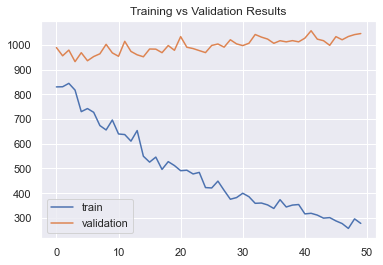

In [33]:
plt.title('Training vs Validation Results')
plt.plot(np.arange(n_epochs), vis_training_loss, label='train')
plt.plot(np.arange(n_epochs), vis_validation_loss, label='validation')
plt.legend()
plt.show()


## Load the Model with the Lowest Validation Loss


In [34]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Test the Trained Network


In [37]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))



<ipython-input-28-e4fce78192bf>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.output(x))


Test Loss: 0.070645

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 98% (963/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 97% (952/974)
Test Accuracy of     9: 97% (987/1009)

Test Accuracy (Overall): 98% (9821/10000)


## Visualize Sample Test Results



<ipython-input-28-e4fce78192bf>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.output(x))
<ipython-input-39-5b48f93d592e>:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


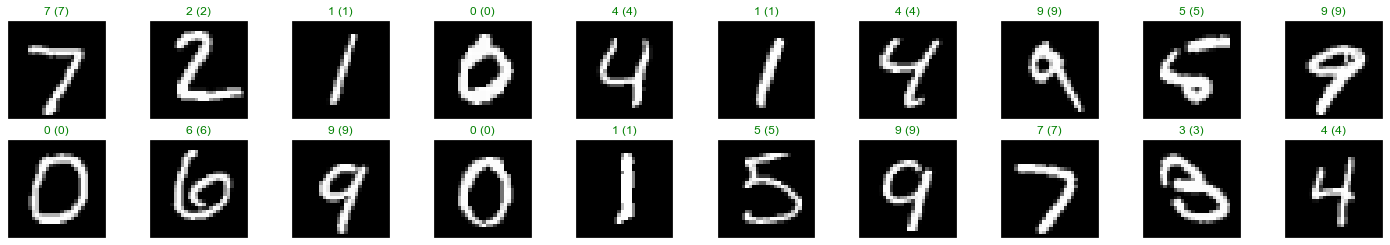

In [39]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))
